In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import cartopy
from scipy.interpolate import interp1d

import data_util as du
from basin_scale_high_flow_attribution import get_huc_counts_gdf

from budyko_analysis import load_budyko_data, add_upstream_basin_budyko_data

## Figure 1: Precipitation and streamflow changes with warming

In [2]:
exp_name_ctrl = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min'
exp_name_dist = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min_p2K'
start_year = 1951
end_year = 2020

ctrl_data = du.sel_conus_land(xr.open_mfdataset(
    f'/archive/Marc.Prange/na_data/{exp_name_ctrl}/{exp_name_ctrl}_na_*.nc')
    ).dropna('lat', how='all').dropna('lon', how='all')
p2K_data = du.sel_conus_land(xr.open_mfdataset(
    f'/archive/Marc.Prange/na_data/{exp_name_dist}/{exp_name_dist}_na_*.nc')
    ).dropna('lat', how='all').dropna('lon', how='all')

streamflow_ctrl = ctrl_data['rv_o_h2o'].load()
streamflow_p2K = p2K_data['rv_o_h2o'].load()
precip_ctrl = ctrl_data['pr'].load()
precip_p2K = p2K_data['pr'].load()
ar_precip_ctrl = ctrl_data['ar_pr'].load()
ar_precip_p2K = p2K_data['ar_pr'].load()

quantile = 1-1/365.25
mean_streamflow_ctrl = streamflow_ctrl.mean(dim='time')
mean_streamflow_p2K = streamflow_p2K.mean(dim='time')
p99_streamflow_ctrl = streamflow_ctrl.quantile(quantile, dim='time')
p99_streamflow_p2K = streamflow_p2K.quantile(quantile, dim='time')
mean_precip_ctrl = precip_ctrl.mean(dim='time')
mean_precip_p2K = precip_p2K.mean(dim='time')
p99_precip_ctrl = precip_ctrl.quantile(quantile, dim='time')
p99_precip_p2K = precip_p2K.quantile(quantile, dim='time')
sum_ar_precip_ctrl = ar_precip_ctrl.sum(dim='time')
sum_ar_precip_p2K = ar_precip_p2K.sum(dim='time')
p99_ar_precip_ctrl = ar_precip_ctrl.quantile(quantile, dim='time')
p99_ar_precip_p2K = ar_precip_p2K.quantile(quantile, dim='time')

dT = du.get_global_mean_dT(exp_name_ctrl, exp_name_dist, start_year, end_year)

mean_streamflow_change = (mean_streamflow_p2K - mean_streamflow_ctrl)/dT
mean_streamflow_rel_change = mean_streamflow_change/mean_streamflow_ctrl*100
p99_streamflow_change = (p99_streamflow_p2K - p99_streamflow_ctrl)/dT
p99_streamflow_rel_change = p99_streamflow_change/p99_streamflow_ctrl*100

mean_precip_change = (mean_precip_p2K - mean_precip_ctrl)/dT
mean_precip_rel_change = mean_precip_change/mean_precip_ctrl*100
p99_precip_change = (p99_precip_p2K - p99_precip_ctrl)/dT
p99_precip_rel_change = p99_precip_change/p99_precip_ctrl*100

sum_ar_precip_change = (sum_ar_precip_p2K - sum_ar_precip_ctrl)/dT
sum_ar_precip_rel_change = sum_ar_precip_change/sum_ar_precip_ctrl*100
p99_ar_precip_change = (p99_ar_precip_p2K - p99_ar_precip_ctrl)/dT
p99_ar_precip_rel_change = p99_ar_precip_change/p99_ar_precip_ctrl*100

/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [34]:
def plot_daily_cdf_change_with_warming(
        axis, data_ctrl, data_dist, variables, var_labels, min_vals, dT, months):
    data_ctrl = data_ctrl.sel(time=data_ctrl.time.dt.month.isin(months))
    data_dist = data_dist.sel(time=data_dist.time.dt.month.isin(months))
    pr_x = np.logspace(-3, np.log10(90), 200, endpoint=True)
    pctls = (100 - pr_x)
    f1=interp1d(pctls, pr_x, fill_value='extrapolate')
    color_dict = {
        'conus': 'black',
        'east': 'royalblue',
        'mountainous west': 'firebrick',
        'west coast': 'forestgreen'
    }
    ls_dict = {
        'precipitation': '-',
        'AR precipitation': '--',
        'streamflow': 'dotted',
    }
    axis.hlines(0, 0.001, 90, color='gray', ls='-', lw=0.7)
    for var, min_val, var_label in zip(variables, min_vals, var_labels):
        var_data_ctrl = data_ctrl[var]
        var_data_dist = data_dist[var]
        var_data_ctrl = var_data_ctrl.where(var_data_ctrl >= min_val)#.dropna('case')
        var_data_dist = var_data_dist.where(var_data_dist >= min_val)#.dropna('case')
        if var_label == 'streamflow':
            for region, region_func in zip(
                ['conus', 'east', 'mountainous west', 'west coast'], 
                [du.sel_conus_land, du.sel_conus_east, du.sel_conus_mountainous_west, du.sel_conus_west_coast]):
                var_data_ctrl_pctl_spatial = region_func(var_data_ctrl).dropna(
                    'lat', how='all').dropna('lon', how='all').load().quantile(pctls/100, dim='time')
                var_data_dist_pctl_spatial = region_func(var_data_dist).dropna(
                    'lat', how='all').dropna('lon', how='all').load().quantile(pctls/100, dim='time')
                pctl_spatial_diff = var_data_dist_pctl_spatial - var_data_ctrl_pctl_spatial
                pctl_spatial_diff_rel = pctl_spatial_diff/var_data_ctrl_pctl_spatial
                pctl_spatial_diff_rel_mean = pctl_spatial_diff_rel.mean(['lat', 'lon'])
                pctl_spatial_diff_rel_std = pctl_spatial_diff_rel.std(['lat', 'lon']) / \
                        np.sqrt(pctl_spatial_diff_rel.stack({'loc': ('lat', 'lon')}).dropna('loc').shape[-1])
                axis.plot(
                pr_x, pctl_spatial_diff_rel_mean/dT*100, 
                label=f'{var_label}\n{region}', lw=1, color=color_dict[region], ls=ls_dict[var_label])
                axis.fill_between(
                    pr_x, 
                    (pctl_spatial_diff_rel_mean + pctl_spatial_diff_rel_std)/dT*100, 
                    (pctl_spatial_diff_rel_mean - pctl_spatial_diff_rel_std)/dT*100,
                    alpha=0.2, color=color_dict[region])
        else:
            var_data_ctrl_pctl_spatial = var_data_ctrl.load().quantile(pctls/100, dim='time')
            var_data_dist_pctl_spatial = var_data_dist.load().quantile(pctls/100, dim='time')
            pctl_spatial_diff = var_data_dist_pctl_spatial - var_data_ctrl_pctl_spatial
            pctl_spatial_diff_rel = pctl_spatial_diff/var_data_ctrl_pctl_spatial
            pctl_spatial_diff_rel_mean = pctl_spatial_diff_rel.mean(['lat', 'lon'])
            pctl_spatial_diff_rel_std = pctl_spatial_diff_rel.std(['lat', 'lon']) / \
                    np.sqrt(pctl_spatial_diff_rel.stack({'loc': ('lat', 'lon')}).dropna('loc').shape[-1])
            # exp_ref_pctl_spatial_mean = exp_ref_pctl_spatial.mean(['lat', 'lon'])
            axis.plot(
                pr_x, pctl_spatial_diff_rel_mean/dT*100, 
                label=f'{var_label}\nconus', lw=1, color=color_dict['conus'], ls=ls_dict[var_label])
            axis.fill_between(
                pr_x, 
                (pctl_spatial_diff_rel_mean + pctl_spatial_diff_rel_std)/dT*100, 
                (pctl_spatial_diff_rel_mean - pctl_spatial_diff_rel_std)/dT*100,
                alpha=0.2, color=color_dict['conus'])
    axis.hlines(7, 0.001, 90, color='red', ls='-', lw=0.7)
    axis.text(f1(12), 7.5, 'CC: 7% K$^{-1}$', fontsize=10, color='red')
    axis.vlines(f1((1-1/365.25)*100), -12, 12, color='gray', ls='-', lw=0.7)
    axis.text(f1((1-1/365.25)*100), -11.5, '1 year$^{-1}$', fontsize=10, color='black')
    axis.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
    axis.set_yticks([-12, -9, -6, -3, 0, 3, 6, 9, 12])
    axis.set_ylim([-12, 12])
    axis.tick_params(axis='y', labelsize=12)
    axis.set_ylabel('rel. change'+' [% K$^{-1}$]', fontsize=12, labelpad=1)
    axis.set_xlabel('Percentile', fontsize=12)
    axis.set_xscale('log')
    axis.set_xticks((f1([10,90,99,99.9,99.99,99.999])))
    axis.set_xticklabels(['10','90','99','99.9','99.99','99.999'], fontsize=12)
    axis.set_xlim(0.001, 90)
    axis.invert_xaxis()
    return axis

/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/work/Marc.Prange/.conda/envs/work_python/lib/python3.11/si

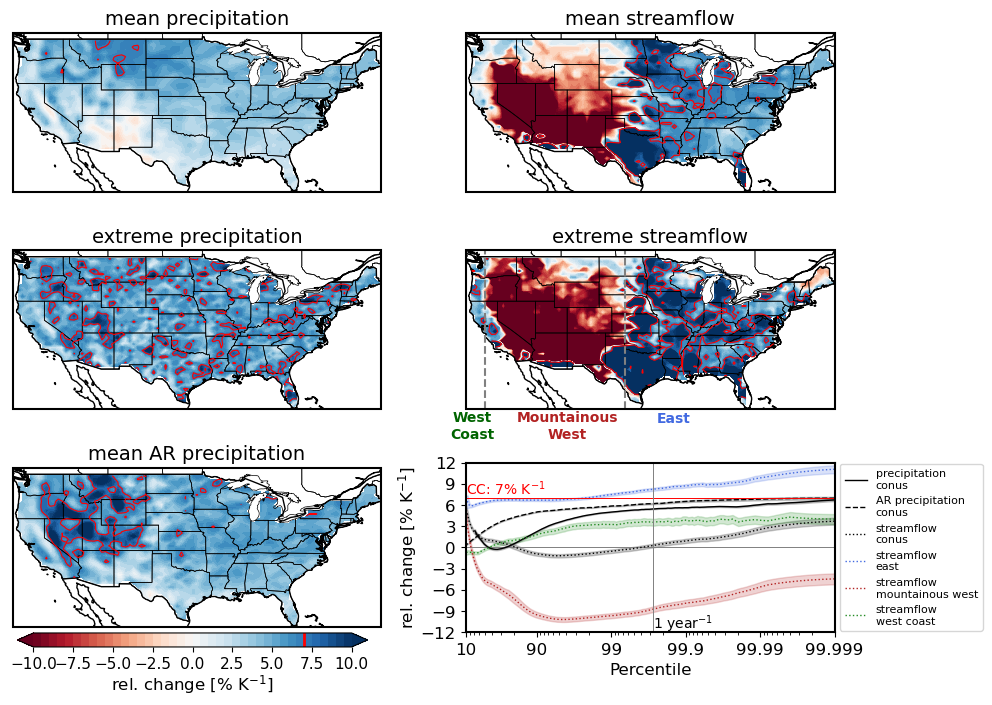

In [39]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree())
qm = ax1.contourf(
    mean_precip_ctrl.lon, mean_precip_ctrl.lat,
    mean_precip_rel_change, levels=np.arange(-10, 10.5, 0.5),
    cmap='RdBu', extend='both')
ax1.contour(mean_precip_ctrl.lon, mean_precip_ctrl.lat, mean_precip_rel_change, 
            levels=[7], colors='red', linestyles=['-'], linewidths=[0.8])
ax1.set_title('mean precipitation', fontsize=14)

ax2 = fig.add_subplot(3, 2, 3, projection=ccrs.PlateCarree())
qm = ax2.contourf(
    p99_precip_rel_change.lon, p99_precip_rel_change.lat,
    p99_precip_rel_change, levels=np.arange(-10, 10.5, 0.5),
    cmap='RdBu', extend='both')
ax2.contour(p99_precip_ctrl.lon, p99_precip_ctrl.lat, p99_precip_rel_change, 
            levels=[7], colors='red', linestyles=['-'], linewidths=[0.8])
ax2.set_title('extreme precipitation', fontsize=14)

ax3 = fig.add_subplot(3, 2, 5, projection=ccrs.PlateCarree())
qm = ax3.contourf(
    sum_ar_precip_rel_change.lon, sum_ar_precip_rel_change.lat,
    sum_ar_precip_rel_change, levels=np.arange(-10, 10.5, 0.5),
    cmap='RdBu', extend='both')
ax3.contour(sum_ar_precip_ctrl.lon, sum_ar_precip_ctrl.lat, sum_ar_precip_rel_change, 
            levels=[7], colors='red', linestyles=['-'], linewidths=[0.8])
ax3.set_title('mean AR precipitation', fontsize=14)

ax4 = fig.add_subplot(3, 2, 2, projection=ccrs.PlateCarree())
qm = ax4.contourf(
    mean_streamflow_rel_change.lon, mean_streamflow_rel_change.lat,
    mean_streamflow_rel_change, levels=np.arange(-10, 10.5, 0.5),
    cmap='RdBu', extend='both') 
ax4.contour(mean_streamflow_ctrl.lon, mean_streamflow_ctrl.lat, mean_streamflow_rel_change, 
            levels=[7], colors='red', linestyles=['-'], linewidths=[0.8])
ax4.set_title('mean streamflow', fontsize=14)

ax5 = fig.add_subplot(3, 2, 4, projection=ccrs.PlateCarree())
qm = ax5.contourf(
    p99_streamflow_rel_change.lon, p99_streamflow_rel_change.lat,
    p99_streamflow_rel_change, levels=np.arange(-10, 10.5, 0.5),
    cmap='RdBu', extend='both')
ax5.contour(p99_streamflow_ctrl.lon, p99_streamflow_ctrl.lat, p99_streamflow_rel_change, 
            levels=[7], colors='red', linestyles=['-'], linewidths=[0.8])
cbar_ax = fig.add_axes([0.02, 0.065, 0.35, 0.02])  # Create a new axis for the colorbar
cbar = plt.colorbar(qm, cax=cbar_ax,
                    shrink=0.8, 
                    orientation='horizontal', 
                    pad=0.02,
                    aspect=20
                    )
cbar.ax.plot([7, 7], [0, 1], color='red', linewidth=2)
cbar.ax.tick_params(labelsize=11)
cbar.set_label('rel. change [% K$^{-1}$]', fontsize=12, labelpad=0.3)
ax5.set_title('extreme streamflow', fontsize=14)
ax5.vlines(-100, 25, 50, color='gray', ls='--', lw=1.5)
ax5.vlines(-122, 25, 50, color='gray', ls='--', lw=1.5)
ax5.text(-95, 23, 'East', fontsize=10, color='royalblue', weight='bold')
ax5.text(-109, 20.5, 'Mountainous\nWest', fontsize=10, color='firebrick', weight='bold', ha='center')
ax5.text(-124, 20.5, 'West\nCoast', rotation=0, fontsize=10, color='darkgreen', weight='bold', ha='center')

ax6 = fig.add_subplot(3, 2, 6)
plot_daily_cdf_change_with_warming(
    ax6, ctrl_data, p2K_data, 
    variables=['pr', 'ar_pr', 'rv_o_h2o'], 
    var_labels=['precipitation', 'AR precipitation', 'streamflow'], 
    min_vals=[0, 0, 0], dT=dT, months=np.arange(1, 13))

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.coastlines()
    ax.set_extent([-125, -67, 25, 50], crs=ccrs.PlateCarree()) # CONUS bounds
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=1)
    ax.add_feature(cartopy.feature.STATES, linestyle='-', lw=0.5)
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.tight_layout()
plt.savefig('plots/paper_ncc/figure1_v2.pdf', bbox_inches='tight')

## Figure 2: Streamflow attribution

In [16]:
exp_name_ctrl = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min'
exp_name_p2K = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min_p2K'
huc_level = 4
start_year = 1951
end_year = 2020
conus_extent = [-125, -67, 25, 50]
huc_counts_gdf_ctrl = get_huc_counts_gdf(exp_name_ctrl, huc_level, start_year, end_year, grouped_monthly=False)
huc_counts_gdf_p2K = get_huc_counts_gdf(exp_name_p2K, huc_level, start_year, end_year, grouped_monthly=False)
dT = du.get_global_mean_dT(exp_name_ctrl, exp_name_p2K, start_year, end_year)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:11<00:00,  6.31it/s]


In [28]:
def plot_precip_ar_precip_melt_event_maps(basin_gdf_ctrl, basin_gdf_p2K, dT, region_extent, output_path, plot_text=True):
    """
    Plot maps showing the number of precip_events, ar_precip_events, melt_events, 
    precip_melt_events, ar_precip_melt_events, and their respective "to_attributed_fraction" 
    in a two-row layout.

    Args:
        basin_gdf_ctrl (GeoDataFrame): GeoDataFrame with event counts and geometries.
        basin_gdf_p2K (GeoDataFrame): GeoDataFrame with event counts and geometries.
        region_extent (list): [min_lon, max_lon, min_lat, max_lat] defining the map extent.
        output_path (str): Path to save the output figure.
    """
    # Define projection
    projection = ccrs.PlateCarree()

    # Create subplots with 2 rows and 3 columns
    fig, axes = plt.subplots(3, 2, figsize=(7, 5), subplot_kw={'projection': projection})

    # Define plotting configurations for the second row (Event Fractions)
    fraction_plot_configs = [
        {
            'column': 'attributed_events',
            'cmap': 'binary',
            'title': 'Total Attributed Events',
            'legend_label': 'Fraction [%]',
            'vmin': 0,
            'vmax': 100
        },
        {
            'column': 'ar_precip_to_attributed_fraction',
            'cmap': 'binary',
            'title': 'AR Precipitation Events',
            'legend_label': 'Fraction [%]',
            'vmin': 0,
            'vmax': 100
        },
        {
            'column': 'precip_to_attributed_fraction',
            'cmap': 'binary',
            'title': 'Non-AR Precipitation Events',
            'legend_label': 'Fraction [%]',
            'vmin': 0,
            'vmax': 100
        },
        {
            'column': 'melt_to_attributed_fraction',
            'cmap': 'binary',
            'title': 'Melt Events',
            'legend_label': 'Fraction [%]',
            'vmin': 0,
            'vmax': 100
        },
    ]

    # Plot the first row (Event Fractions)
    for ax, config in zip(axes[:, 0], fraction_plot_configs):
        print(config['column'])
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle='-')
        west_coast_gdf = basin_gdf_ctrl[basin_gdf_ctrl.geometry.centroid.x <= -120]
        mountainous_west_gdf = basin_gdf_ctrl[(basin_gdf_ctrl.geometry.centroid.x > -120) & (basin_gdf_ctrl.geometry.centroid.x <= -100)]
        east_gdf = basin_gdf_ctrl[(basin_gdf_ctrl.geometry.centroid.x > -100) & (basin_gdf_ctrl.geometry.centroid.x <= -67)]
        west_coast_gdf.plot(column=config['column'],
                       cmap=config['cmap'],
                       linewidth=0.3,
                       ax=ax,
                       edgecolor='forestgreen',
                       legend=False,
                       vmin=config['vmin'],
                       vmax=config['vmax'])
        mountainous_west_gdf.plot(column=config['column'],
                       cmap=config['cmap'],
                       linewidth=0.3,
                       ax=ax,
                       edgecolor='firebrick',
                       legend=False,
                       vmin=config['vmin'],
                       vmax=config['vmax'])
        if config['column'] == 'melt_to_attributed_fraction':
            cbar_ax = fig.add_axes([0.04, 0, 0.42, 0.02])
            legend_kwds = {'orientation': 'horizontal', 
                           'fraction': 0.036, 
                           'pad': 0.04}
            legend = True
        else:
            cbar_ax = None
            legend_kwds = None
            legend = False
        east_gdf.plot(column=config['column'],
                       cmap=config['cmap'],
                       linewidth=0.3,
                       ax=ax,
                       edgecolor='royalblue',
                       legend=legend,
                       vmin=config['vmin'],
                       vmax=config['vmax'], 
                       cax=cbar_ax,
                       legend_kwds=legend_kwds)
        if config['column'] == 'melt_to_attributed_fraction':
            cbar_ax.set_xlabel(r'$\frac{N_{driver}}{N_{attr}}$ (CTRL) [%]', fontsize=10)
            cbar_ax.tick_params(labelsize=10)
        if plot_text:
            # Display the number on the plotted map at a suitable location for each river basin
            for idx, row in basin_gdf_ctrl.iterrows():
                if row.geometry:
                    lon_pos = row.geometry.centroid.x
                    lat_pos = row.geometry.centroid.y
                    if (lon_pos > region_extent[0] and lon_pos < region_extent[1] 
                        and lat_pos > region_extent[2] and lat_pos < region_extent[3]):
                        ax.text(lon_pos, lat_pos, 
                                f"{row[config['column']]:.0f}", 
                                horizontalalignment='center', 
                                verticalalignment='center', 
                                fontsize=7, 
                                color='black',
                                fontweight='bold')
        # Set title
        ax.set_title(config['title'], fontsize=12)

    # Calculate relative changes and make second row of plots
    diff_gdf = basin_gdf_ctrl.copy()
    diff_gdf['delta_precip_fraction'] = (basin_gdf_p2K['precip_events'] - 
                                          basin_gdf_ctrl['precip_events']) \
                                         / basin_gdf_ctrl['attributed_events'] / dT * 100
    diff_gdf['delta_ar_precip_fraction'] = (basin_gdf_p2K['ar_precip_events'] - 
                                             basin_gdf_ctrl['ar_precip_events']) \
                                             / basin_gdf_ctrl['attributed_events'] / dT * 100
    diff_gdf['delta_melt_fraction'] = (basin_gdf_p2K['melt_events'] - 
                                        basin_gdf_ctrl['melt_events']) \
                                        / basin_gdf_ctrl['attributed_events'] / dT * 100
    delta_plot_configs = [
        {
            'column': 'delta_ar_precip_fraction',
            'cmap': 'RdBu',
            'vmin': -30,
            'vmax': 30,
            'title': 'Change in AR Precipitation Events'
        },
        {
            'column': 'delta_precip_fraction',
            'cmap': 'RdBu',
            'vmin': -30,
            'vmax': 30,
            'title': 'Change in Non-AR Precipitation Events'
        },
        {
            'column': 'delta_melt_fraction',
            'cmap': 'RdBu',
            'vmin': -30,
            'vmax': 30,
            'title': 'Change in Melt Events'
        },
    ]
    for ax, config in zip(axes[:, 1], delta_plot_configs):
        print(config['column'])
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle='-')
        west_coast_gdf = diff_gdf[diff_gdf.geometry.centroid.x <= -120]
        mountainous_west_gdf = diff_gdf[(diff_gdf.geometry.centroid.x > -120) & (diff_gdf.geometry.centroid.x <= -100)]
        east_gdf = diff_gdf[(diff_gdf.geometry.centroid.x > -100) & (diff_gdf.geometry.centroid.x <= -67)]

        west_coast_gdf.plot(column=config['column'],
                       cmap=config['cmap'],
                       linewidth=0.3,
                       ax=ax,
                       edgecolor='forestgreen',
                       legend=False,
                       vmin=config['vmin'],
                       vmax=config['vmax'])
        mountainous_west_gdf.plot(column=config['column'],
                       cmap=config['cmap'],
                       linewidth=0.3,
                       ax=ax,
                       edgecolor='firebrick',
                       legend=False,
                       vmin=config['vmin'],
                       vmax=config['vmax'])
        if config['column'] == 'delta_melt_fraction':
            cbar_ax = fig.add_axes([0.53, 0, 0.42, 0.02])
            legend_kwds = {'orientation': 'horizontal', 
                           'fraction': 0.036, 
                           'pad': 0.04}
            legend = True
        else:
            cbar_ax = None
            legend_kwds = None
            legend = False
        east_gdf.plot(column=config['column'],
                       cmap=config['cmap'],
                       linewidth=0.3,
                       ax=ax,
                       edgecolor='royalblue',
                       legend=legend,
                       vmin=config['vmin'],
                       vmax=config['vmax'], 
                       cax=cbar_ax,
                       legend_kwds=legend_kwds)
        if config['column'] == 'delta_melt_fraction':
            cbar_ax.set_xlabel(r'rel. change in $\frac{N_{driver}}{N_{attr}}$ [% K$^{-1}$]', fontsize=10)
            cbar_ax.tick_params(labelsize=10)
        # Set title
        ax.set_title(config['title'], fontsize=12)
    for ax in axes.flatten():
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        # Add geographical features
        # ax.add_feature(cfeature.RIVERS)
        ax.add_feature(cfeature.LAKES)
        ax.set_extent(region_extent, crs=projection)

    # ytitle_axis = fig.add_axes([0.01, 0.5, 0.01, 0.15])
    # axes[0, 0].text(-0.07, 0.5, 'CTRL', fontsize=14, weight='bold', 
    #                 transform=axes[0, 0].transAxes, verticalalignment='center', 
    #                 rotation=90)
    # axes[1, 0].text(-0.1, 0.5, r'$\mathbf{\frac{P2K-CTRL}{CTRL \cdot dT}}$', 
    #                 fontsize=14, 
    #                 transform=axes[1, 0].transAxes, verticalalignment='center', 
    #                 rotation=90)
    plt.tight_layout()
    # plt.show()
    fig.savefig(output_path, bbox_inches='tight', dpi=300)
    # plt.close()
    return fig, axes

ar_precip_to_attributed_fraction
precip_to_attributed_fraction
melt_to_attributed_fraction
delta_ar_precip_fraction
delta_precip_fraction
delta_melt_fraction


/tmp/ipykernel_44188/1134663392.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


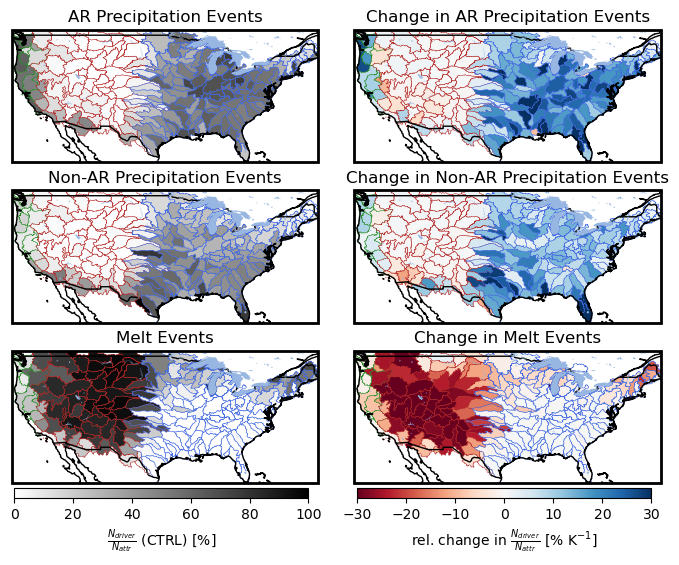

In [29]:
fig, axes = plot_precip_ar_precip_melt_event_maps(
    huc_counts_gdf_ctrl, huc_counts_gdf_p2K, dT, 
    conus_extent, 'plots/paper_ncc/figure2_v2.png', plot_text=False)

# Figure 3: Seasonality in high-flows induced by various drivers and changes with warming

In [2]:
exp_name_ctrl = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min'
exp_name_p2K = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min_p2K'
huc_level = 4
start_year = 1951
end_year = 2020
conus_extent = [-125, -67, 25, 50]
huc_counts_gdf_ctrl_monthly = get_huc_counts_gdf(exp_name_ctrl, huc_level, start_year, end_year, grouped_monthly=True)
huc_counts_gdf_p2K_monthly = get_huc_counts_gdf(exp_name_p2K, huc_level, start_year, end_year, grouped_monthly=True)
dT = du.get_global_mean_dT(exp_name_ctrl, exp_name_p2K, start_year, end_year)

  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:10<00:00,  6.81it/s]


In [57]:
def add_missing_months(gdf, event_types):
    missing_rows = []
    for month in range(1, 13):
        if month not in gdf['time'].values:
            missing_row = gdf.iloc[0].copy()
            missing_row['time'] = month
            for event in event_types:
                missing_row[event] = 0
            missing_rows.append(missing_row)
    if missing_rows:
        gdf = pd.concat([gdf, pd.DataFrame(missing_rows)])
    return gdf


def plot_regional_seasonal_cycles(control_gdf, warming_gdf, dT, output_path):
    """
    Plot seasonal cycles of precip_events, ar_precip_events, melt_events, 
    precip_melt_events, and ar_precip_melt_events for a specified basin ID 
    comparing control and warming climate scenarios.
    
    Args:
        control_gdf (GeoDataFrame): GeoDataFrame grouped by basin_id and month for the control scenario.
        warming_gdf (GeoDataFrame): GeoDataFrame grouped by basin_id and month for the warming scenario.
        dT (float): Global mean temperature change [K].
        output_path (str): Path to save the output figure.
    """
    # List of event types to plot
    event_types = [
        'attributed_events',
        'ar_precip_events',
        'precip_events',
        'melt_events',
    ]
    event_labels = [
        'Total Events',
        'AR Precipitation Events',
        'Non-AR Precipitation Events',
        'Melt Events',
    ]
    
    # Create gdf for each region
    west_coast_gdf_ctrl = control_gdf[control_gdf.geometry.centroid.x <= -120]
    mountainous_west_gdf_ctrl = control_gdf[
        (control_gdf.geometry.centroid.x > -120) & 
        (control_gdf.geometry.centroid.x <= -100)]
    east_gdf_ctrl = control_gdf[
        (control_gdf.geometry.centroid.x > -100) & 
        (control_gdf.geometry.centroid.x <= -67)]
    west_coast_gdf_p2K = warming_gdf[warming_gdf.geometry.centroid.x <= -120]
    mountainous_west_gdf_p2K = warming_gdf[
        (warming_gdf.geometry.centroid.x > -120) & 
        (warming_gdf.geometry.centroid.x <= -100)]
    east_gdf_p2K = warming_gdf[
        (warming_gdf.geometry.centroid.x > -100) & 
        (warming_gdf.geometry.centroid.x <= -67)]
    # Add missing months
    west_coast_gdf_ctrl = add_missing_months(west_coast_gdf_ctrl, event_types)
    mountainous_west_gdf_ctrl = add_missing_months(mountainous_west_gdf_ctrl, event_types)
    east_gdf_ctrl = add_missing_months(east_gdf_ctrl, event_types)
    west_coast_gdf_p2K = add_missing_months(west_coast_gdf_p2K, event_types)
    mountainous_west_gdf_p2K = add_missing_months(mountainous_west_gdf_p2K, event_types)
    east_gdf_p2K = add_missing_months(east_gdf_p2K, event_types)
    # Group by time and sum
    west_coast_gdf_ctrl = west_coast_gdf_ctrl.drop(
        columns=['geometry']).groupby('time').sum()
    mountainous_west_gdf_ctrl = mountainous_west_gdf_ctrl.drop(
        columns=['geometry']).groupby('time').sum()
    east_gdf_ctrl = east_gdf_ctrl.drop(
        columns=['geometry']).groupby('time').sum()
    west_coast_gdf_p2K = west_coast_gdf_p2K.drop(
        columns=['geometry']).groupby('time').sum()
    mountainous_west_gdf_p2K = mountainous_west_gdf_p2K.drop(
        columns=['geometry']).groupby('time').sum()
    east_gdf_p2K = east_gdf_p2K.drop(
        columns=['geometry']).groupby('time').sum()
    
    # Define month labels
    months = np.arange(1, 13)
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Create subplots
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 8), 
    sharey='col', sharex='col')
    
    # Plot each event type
    for ax, event, label in zip(axes[:, 0], event_types, event_labels):
        ax.plot(
            months, 
            west_coast_gdf_ctrl[event]/
            west_coast_gdf_ctrl['attributed_events'].sum()*100, 
            label='west coast', color='forestgreen', marker='o', lw=2)
        ax.plot(
            months, 
            mountainous_west_gdf_ctrl[event]/mountainous_west_gdf_ctrl['attributed_events'].sum()*100, 
            label='mountainous west', color='firebrick', marker='o', lw=2)
        ax.plot(
            months, 
            east_gdf_ctrl[event]/east_gdf_ctrl['attributed_events'].sum()*100, 
            label='east', color='royalblue', marker='o', lw=2)
        ax.set_title(label, fontsize=14)
        # ax.grid(True)

    for ax, event, label in zip(axes[:, 1], event_types, event_labels):
        ax.plot(
            months,
            (west_coast_gdf_p2K[event] - 
            west_coast_gdf_ctrl[event])/
            west_coast_gdf_ctrl['attributed_events'].sum()/dT*100, 
            label='west coast', color='forestgreen', marker='o', lw=2)
        ax.plot(
            months, 
            (mountainous_west_gdf_p2K[event] - 
            mountainous_west_gdf_ctrl[event])/
            mountainous_west_gdf_ctrl['attributed_events'].sum()/dT*100, 
            label='mountainous west', color='firebrick', marker='o', lw=2)
        ax.plot(
            months, 
            (east_gdf_p2K[event] - 
            east_gdf_ctrl[event])/
            east_gdf_ctrl['attributed_events'].sum()/dT*100, 
            label='east', color='royalblue', marker='o', lw=2)
        ax.set_title(f'Change in {label}', fontsize=14)
        # ax.grid(True)
    
    axes[0, 0].legend(fontsize=10)
    axes[-1, 0].set_xticks(months)
    axes[-1, 0].set_xticklabels(month_labels, fontsize=12, rotation=45)
    axes[-1, 1].set_xticks(months)
    axes[-1, 1].set_xticklabels(month_labels, fontsize=12, rotation=45)
    # Create new axes for the text annotations
    text_ax1 = fig.add_axes([0.08, 0.5, 0.05, 0.2], frame_on=False)  # Adjust position and size as needed
    text_ax2 = fig.add_axes([0.5, 0.5, 0.05, 0.2], frame_on=False)  # Adjust position and size as needed

    text_ax1.text(0, 0, r'$F_{mon}$ (CTRL) [%]', 
                  transform=text_ax1.transAxes, fontsize=13, rotation=90, 
                  ha='center', va='center')
    text_ax2.text(0, 0, r'$\Delta F_{mon}$ (P2K-CTRL) [% K$^{-1}$]', 
                  transform=text_ax2.transAxes, fontsize=13, rotation=90, 
                  ha='center', va='center')
    text_ax1.axis('off')  # Hide the axes
    text_ax2.axis('off')  # Hide the axes
    # Set x-axis labels
    for ax in axes[:, 0]: 
        ax.set_ylim([-3, 33])
        ax.set_yticks([0, 10, 20, 30])
        ax.tick_params(axis='y', labelsize=12)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

    for ax in axes[:, 1]:
        ax.hlines(0, 1, 12, color='black', linestyle='--', lw=1)
        ax.set_ylim([-9, 9])
        ax.set_yticks([-8, -4, 0, 4, 8])
        ax.tick_params(axis='y', labelsize=12)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)  # Increase horizontal space between axes[:, 0] and axes[:, 1]
    # plt.tight_layout()
    # plt.show()
    fig.savefig(output_path, bbox_inches='tight', dpi=300)

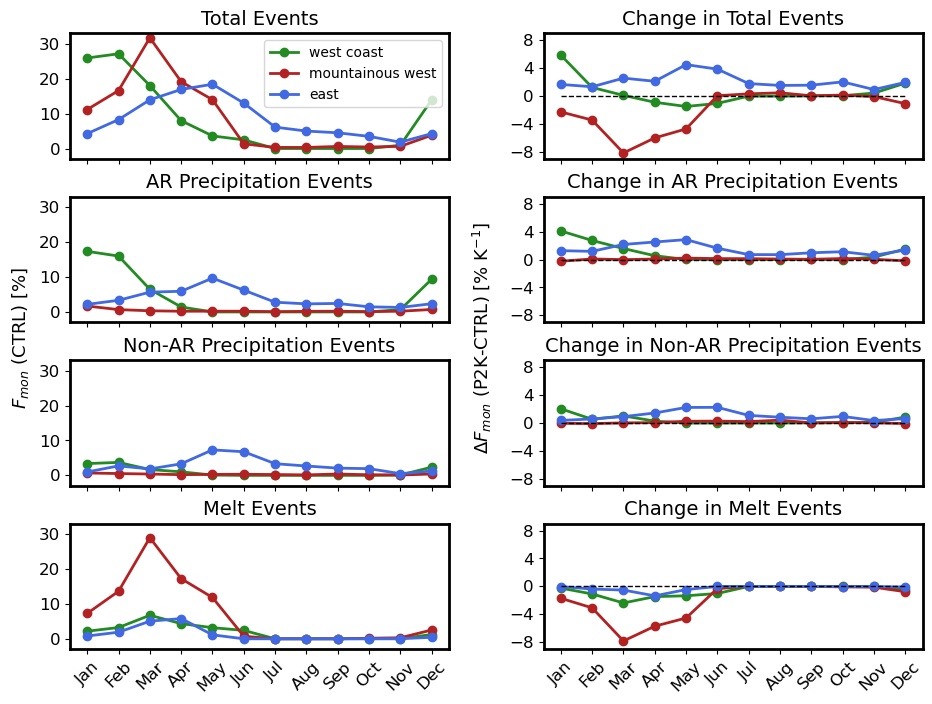

In [58]:
plot_regional_seasonal_cycles(
    huc_counts_gdf_ctrl_monthly, 
    huc_counts_gdf_p2K_monthly, dT,
    'plots/paper_ncc/figure3.png')

## Figure 4: Budyko analysis

In [58]:
exp_name_ctrl = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min'
exp_name_p2K = 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min_p2K'
start_year = 1951
end_year = 2020
conus_extent = [-125, -67, 25, 50]
variables = ['lwdn_sfc', 'lwup_sfc', 'swdn_sfc', 'swup_sfc', 'precip', 
             'evap_land', 't_surf', 'albedo_dir', 'albedo_dif', 'snow', 'melt', 'runf']
subsets = ['atmos', 'atmos', 'atmos', 'atmos', 'atmos', 
           'land', 'atmos', 'land', 'land', 'land', 'land', 'land']
budyko_data_ctrl = load_budyko_data(
    exp_name_ctrl, variables, subsets,region='conus_land', monthly=True)
budyko_data_p2K = load_budyko_data(
    exp_name_p2K, variables, subsets, region='conus_land', monthly=True)
dT = du.get_global_mean_dT(exp_name_ctrl, exp_name_p2K, start_year, end_year)
# budyko_data_ctrl_winter = budyko_data_ctrl.sel(month=budyko_data_ctrl.month.isin([11, 12, 1, 2])).mean('month')
# budyko_data_p2K_winter = budyko_data_p2K.sel(month=budyko_data_p2K.month.isin([11, 12, 1, 2])).mean('month')
# budyko_data_ctrl_summer = budyko_data_ctrl.sel(month=budyko_data_ctrl.month.isin([5, 6, 7, 8])).mean('month')
# budyko_data_p2K_summer = budyko_data_p2K.sel(month=budyko_data_p2K.month.isin([5, 6, 7, 8])).mean('month')
# budyko_data_ctrl_winter = add_upstream_basin_budyko_data(budyko_data_ctrl_winter)
# budyko_data_p2K_winter = add_upstream_basin_budyko_data(budyko_data_p2K_winter)
# budyko_data_ctrl_summer = add_upstream_basin_budyko_data(budyko_data_ctrl_summer)
# budyko_data_p2K_summer = add_upstream_basin_budyko_data(budyko_data_p2K_summer)

Loading budyko data for c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min...: 100%|██████████| 12/12 [00:00<00:00, 53946.03it/s]
Loading budyko data for c192L33_am4p0_amip_HIRESMIP_nudge_wind_30min_p2K...: 100%|██████████| 12/12 [00:00<00:00, 89558.09it/s]


In [59]:
west_coast_budyko_ctrl = budyko_data_ctrl.sel(lon=slice(-125, -120)).mean(dim=['lat', 'lon'])
west_coast_budyko_p2K = budyko_data_p2K.sel(lon=slice(-125, -120)).mean(dim=['lat', 'lon'])
mountainous_west_budyko_ctrl = budyko_data_ctrl.sel(lon=slice(-120, -100)).mean(dim=['lat', 'lon'])
mountainous_west_budyko_p2K = budyko_data_p2K.sel(lon=slice(-120, -100)).mean(dim=['lat', 'lon'])
east_budyko_ctrl = budyko_data_ctrl.sel(lon=slice(-100, -67)).mean(dim=['lat', 'lon'])
east_budyko_p2K = budyko_data_p2K.sel(lon=slice(-100, -67)).mean(dim=['lat', 'lon'])

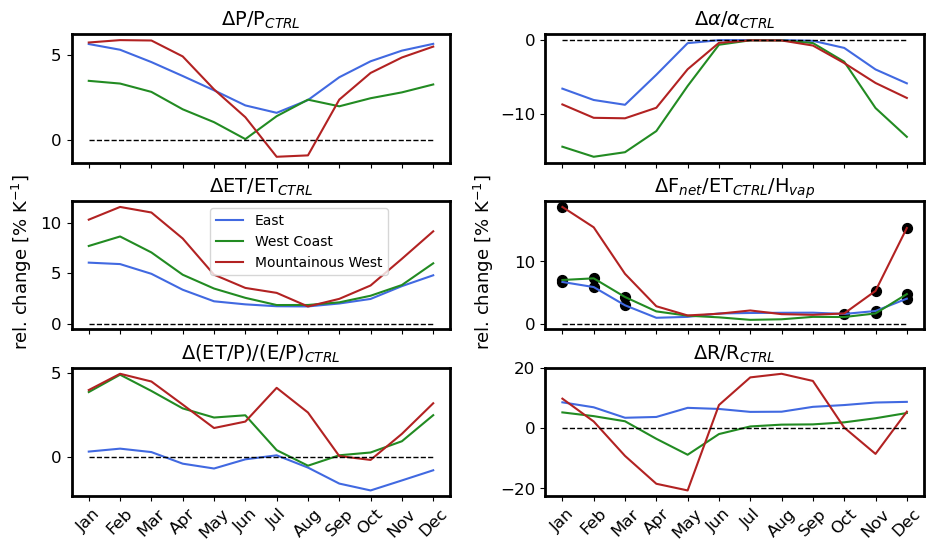

In [102]:
months = np.arange(1, 13)
fig, axes = plt.subplots(3, 2, figsize=(11, 6), sharey=False, sharex=True)
((east_budyko_p2K.precip - east_budyko_ctrl.precip)/east_budyko_ctrl.precip/dT*100).plot(ax=axes[0, 0], color='royalblue', label='East')
((west_coast_budyko_p2K.precip - west_coast_budyko_ctrl.precip)/west_coast_budyko_ctrl.precip/dT*100).plot(ax=axes[0, 0], color='forestgreen', label='West Coast')
((mountainous_west_budyko_p2K.precip - mountainous_west_budyko_ctrl.precip)/mountainous_west_budyko_ctrl.precip/dT*100).plot(ax=axes[0, 0], color='firebrick', label='Mountainous West')
axes[0, 0].set_title(r'$\Delta$P/P$_{CTRL}$', fontsize=14)
# axes[0, 0].set_ylim([-2, 12])
((east_budyko_p2K.evap_land - east_budyko_ctrl.evap_land)/east_budyko_ctrl.evap_land/dT*100).plot(ax=axes[1, 0], color='royalblue', label='East')
((west_coast_budyko_p2K.evap_land - west_coast_budyko_ctrl.evap_land)/west_coast_budyko_ctrl.evap_land/dT*100).plot(ax=axes[1, 0], color='forestgreen', label='West Coast')
((mountainous_west_budyko_p2K.evap_land - mountainous_west_budyko_ctrl.evap_land)/mountainous_west_budyko_ctrl.evap_land/dT*100).plot(ax=axes[1, 0], color='firebrick', label='Mountainous West')
axes[1, 0].set_title(r'$\Delta$ET/ET$_{CTRL}$', fontsize=14)

((east_budyko_p2K.evap_land/east_budyko_p2K.precip - east_budyko_ctrl.evap_land/east_budyko_ctrl.precip)/
 (east_budyko_ctrl.evap_land/east_budyko_ctrl.precip)/dT*100).plot(ax=axes[2, 0], color='royalblue')
((west_coast_budyko_p2K.evap_land/west_coast_budyko_p2K.precip - west_coast_budyko_ctrl.evap_land/west_coast_budyko_ctrl.precip)/(
    west_coast_budyko_ctrl.evap_land/west_coast_budyko_ctrl.precip)/dT*100).plot(ax=axes[2, 0], color='forestgreen')
((mountainous_west_budyko_p2K.evap_land/mountainous_west_budyko_p2K.precip - mountainous_west_budyko_ctrl.evap_land/mountainous_west_budyko_ctrl.precip)/
(mountainous_west_budyko_ctrl.evap_land/mountainous_west_budyko_ctrl.precip)/dT*100).plot(ax=axes[2, 0], color='firebrick')
axes[2, 0].set_title(r'$\Delta$(ET/P)/(E/P)$_{CTRL}$', fontsize=14)

((east_budyko_p2K.albedo_dir - east_budyko_ctrl.albedo_dir)/east_budyko_ctrl.albedo_dir/dT*100).sel(band=1).plot(ax=axes[0, 1], color='royalblue')
((west_coast_budyko_p2K.albedo_dir - west_coast_budyko_ctrl.albedo_dir)/west_coast_budyko_ctrl.albedo_dir/dT*100).sel(band=1).plot(ax=axes[0, 1], color='forestgreen')
((mountainous_west_budyko_p2K.albedo_dir - mountainous_west_budyko_ctrl.albedo_dir)/mountainous_west_budyko_ctrl.albedo_dir/dT*100).sel(band=1).plot(ax=axes[0, 1], color='firebrick')
axes[0, 1].set_title(r'$\Delta \alpha$/$\alpha_{CTRL}$', fontsize=14)

((east_budyko_p2K.net_sfc - east_budyko_ctrl.net_sfc)/east_budyko_ctrl.evap_land/2260/1e3/dT*100).plot(ax=axes[1, 1], color='royalblue')
((west_coast_budyko_p2K.net_sfc - west_coast_budyko_ctrl.net_sfc)/west_coast_budyko_ctrl.evap_land/2260/1e3/dT*100).plot(ax=axes[1, 1], color='forestgreen')
((mountainous_west_budyko_p2K.net_sfc - mountainous_west_budyko_ctrl.net_sfc)/mountainous_west_budyko_ctrl.evap_land/2260/1e3/dT*100).plot(ax=axes[1, 1], color='firebrick')
energy_limited = east_budyko_ctrl.pet_ind < 1
axes[1, 1].scatter(months[energy_limited], ((east_budyko_p2K.net_sfc - east_budyko_ctrl.net_sfc)/east_budyko_ctrl.evap_land/2260/1e3/dT*100)[energy_limited], color='black', marker='o', s=50)
energy_limited = west_coast_budyko_ctrl.pet_ind < 1
axes[1, 1].scatter(months[energy_limited], ((west_coast_budyko_p2K.net_sfc - west_coast_budyko_ctrl.net_sfc)/west_coast_budyko_ctrl.evap_land/2260/1e3/dT*100)[energy_limited], color='black', marker='o', s=50)
energy_limited = mountainous_west_budyko_ctrl.pet_ind < 1
axes[1, 1].scatter(months[energy_limited], ((mountainous_west_budyko_p2K.net_sfc - mountainous_west_budyko_ctrl.net_sfc)/mountainous_west_budyko_ctrl.evap_land/2260/1e3/dT*100)[energy_limited], color='black', marker='o', s=50)
axes[1, 1].set_title(r'$\Delta$F$_{net}$/ET$_{CTRL}$/H$_{vap}$', fontsize=14)

((east_budyko_p2K.runf - east_budyko_ctrl.runf)/(east_budyko_ctrl.runf)/dT*100).plot(ax=axes[2, 1], color='royalblue')
((west_coast_budyko_p2K.runf - west_coast_budyko_ctrl.runf)/(west_coast_budyko_ctrl.runf)/dT*100).plot(ax=axes[2, 1], color='forestgreen')
((mountainous_west_budyko_p2K.runf - mountainous_west_budyko_ctrl.runf)/(mountainous_west_budyko_ctrl.runf)/dT*100).plot(ax=axes[2, 1], color='firebrick')
axes[2, 1].set_title(r'$\Delta$R/R$_{CTRL}$', fontsize=14)

for ax in axes.flatten():
    ax.hlines(0, 1, 12, color='black', linestyle='--', lw=1)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='y', labelsize=12)
    for spine in ax.spines.values():
            spine.set_linewidth(2)
# Create new axes for the text annotations
text_ax1 = fig.add_axes([0.08, 0.5, 0.05, 0.2], frame_on=False)  # Adjust position and size as needed
text_ax2 = fig.add_axes([0.5, 0.5, 0.05, 0.2], frame_on=False)  # Adjust position and size as needed

text_ax1.text(0, 0, r'rel. change [% K$^{-1}$]', 
                transform=text_ax1.transAxes, fontsize=13, rotation=90, 
                ha='center', va='center')
text_ax2.text(0, 0, r'rel. change [% K$^{-1}$]', 
                transform=text_ax2.transAxes, fontsize=13, rotation=90, 
                ha='center', va='center')
text_ax1.axis('off')  # Hide the axes
text_ax2.axis('off')  # Hide the axes
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1, 0].legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.6, 1))
axes[-1, 0].set_xticks(months)
axes[-1, 0].set_xticklabels(month_labels, fontsize=12, rotation=45)
axes[-1, 1].set_xticks(months)
axes[-1, 1].set_xticklabels(month_labels, fontsize=12, rotation=45)
# plt.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.3)
# plt.savefig('plots/paper_ncc/figure3.png', bbox_inches='tight', dpi=300)

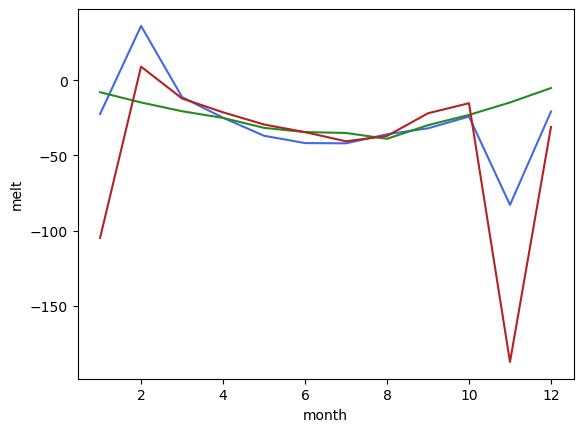

In [71]:
plt.figure()
((east_budyko_p2K.melt - east_budyko_ctrl.melt)/(east_budyko_ctrl.melt)/dT*100).plot(color='royalblue')
((west_coast_budyko_p2K.melt - west_coast_budyko_ctrl.melt)/(west_coast_budyko_ctrl.melt)/dT*100).plot(color='forestgreen')
((mountainous_west_budyko_p2K.melt - mountainous_west_budyko_ctrl.melt)/(mountainous_west_budyko_ctrl.melt)/dT*100).plot(color='firebrick')
axes[2, 1].set_title('Change in melt')
plt.show()

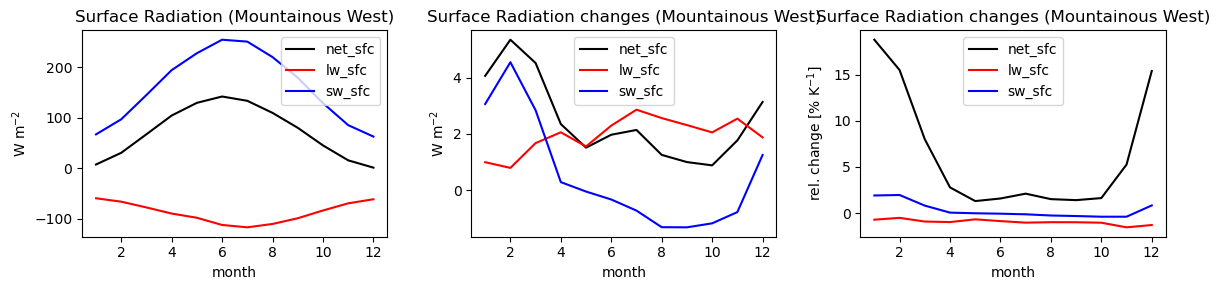

In [53]:
mountainous_west_budyko_ctrl['lw_sfc'] = mountainous_west_budyko_ctrl.lwdn_sfc - mountainous_west_budyko_ctrl.lwup_sfc
mountainous_west_budyko_ctrl['sw_sfc'] = mountainous_west_budyko_ctrl.swdn_sfc - mountainous_west_budyko_ctrl.swup_sfc
mountainous_west_budyko_p2K['lw_sfc'] = mountainous_west_budyko_p2K.lwdn_sfc - mountainous_west_budyko_p2K.lwup_sfc
mountainous_west_budyko_p2K['sw_sfc'] = mountainous_west_budyko_p2K.swdn_sfc - mountainous_west_budyko_p2K.swup_sfc

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
mountainous_west_budyko_ctrl.net_sfc.plot(ax=ax[0], color='black', label='net_sfc')
mountainous_west_budyko_ctrl.lw_sfc.plot(ax=ax[0], color='red', label='lw_sfc')
mountainous_west_budyko_ctrl.sw_sfc.plot(ax=ax[0], color='blue', label='sw_sfc')
ax[0].set_title('Surface Radiation (Mountainous West)')
ax[0].set_ylabel('W m$^{-2}$')
ax[0].legend()

(mountainous_west_budyko_p2K.net_sfc - mountainous_west_budyko_ctrl.net_sfc).plot(ax=ax[1], color='black', label='net_sfc')
(mountainous_west_budyko_p2K.lw_sfc - mountainous_west_budyko_ctrl.lw_sfc).plot(ax=ax[1], color='red', label='lw_sfc')
(mountainous_west_budyko_p2K.sw_sfc - mountainous_west_budyko_ctrl.sw_sfc).plot(ax=ax[1], color='blue', label='sw_sfc')
ax[1].set_title('Surface Radiation changes (Mountainous West)')
ax[1].set_ylabel('W m$^{-2}$')
ax[1].legend()
((mountainous_west_budyko_p2K.net_sfc - mountainous_west_budyko_ctrl.net_sfc)/mountainous_west_budyko_ctrl.evap_land/2260/1e3/dT*100).plot(ax=ax[2], color='black', label='net_sfc')
((mountainous_west_budyko_p2K.lw_sfc - mountainous_west_budyko_ctrl.lw_sfc)/mountainous_west_budyko_ctrl.lw_sfc/dT*100).plot(ax=ax[2], color='red', label='lw_sfc')
((mountainous_west_budyko_p2K.sw_sfc - mountainous_west_budyko_ctrl.sw_sfc)/mountainous_west_budyko_ctrl.sw_sfc/dT*100).plot(ax=ax[2], color='blue', label='sw_sfc')
ax[2].set_title('Surface Radiation changes (Mountainous West)')
ax[2].set_ylabel('rel. change [% K$^{-1}$]')
ax[2].legend()
plt.tight_layout()
plt.show()

In [55]:
mountainous_west_budyko_ctrl.pet_ind > 1

<xarray.DataArray 'pet_ind' (month: 12)>
array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
mountainous_west_budyko_p2K.swup_sfc - mountainous_west_budyko_ctrl.swup_sfc

<xarray.DataArray 'swup_sfc' (month: 12)>
array([ -7.131136  , -10.484234  , -10.056435  ,  -6.5680733 ,
        -1.987587  ,  -0.583416  ,  -0.5682907 ,  -0.65301514,
        -0.6676254 ,  -0.87436676,  -1.9451294 ,  -4.4350586 ],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [39]:
mountainous_west_budyko_p2K.lwup_sfc - mountainous_west_budyko_ctrl.lwup_sfc

<xarray.DataArray 'lwup_sfc' (month: 12)>
array([13.255829, 14.059662, 13.223206, 12.731903, 13.412384, 14.84021 ,
       17.125397, 17.520935, 15.270172, 12.788147, 11.066711, 11.889191],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [40]:
mountainous_west_budyko_p2K.lwdn_sfc - mountainous_west_budyko_ctrl.lwdn_sfc

<xarray.DataArray 'lwdn_sfc' (month: 12)>
array([14.254623, 14.856979, 14.900116, 14.791168, 14.96991 , 17.137085,
       19.986359, 20.085083, 17.58496 , 14.84433 , 13.610321, 13.769104],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

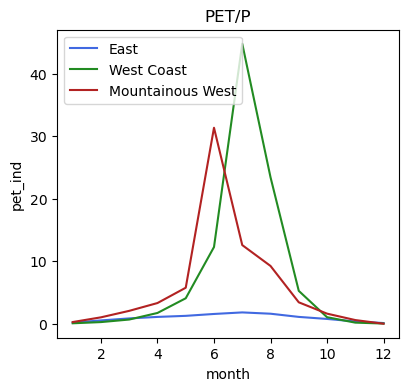

In [6]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
east_pet_ind_ctrl.plot(ax=ax, color='royalblue', label='East')
west_coast_pet_ind_ctrl.plot(ax=ax, color='forestgreen', label='West Coast')
mountainous_west_pet_ind_ctrl.plot(ax=ax, color='firebrick', label='Mountainous West')
ax.set_title('PET/P')
ax.legend()
# ax.set_ylim([0, 10])

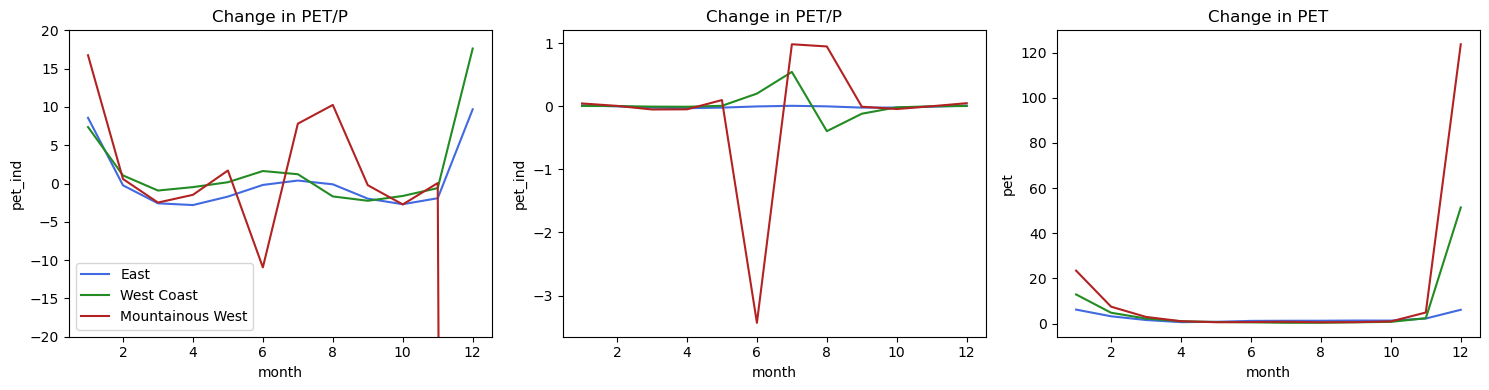

In [7]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)
((east_pet_ind_p2K - east_pet_ind_ctrl)/east_pet_ind_ctrl/dT*100).plot(ax=ax, color='royalblue', label='East')
((west_coast_pet_ind_p2K - west_coast_pet_ind_ctrl)/west_coast_pet_ind_ctrl/dT*100).plot(ax=ax, color='forestgreen', label='West Coast')
((mountainous_west_pet_ind_p2K - mountainous_west_pet_ind_ctrl)/mountainous_west_pet_ind_ctrl/dT*100).plot(ax=ax, color='firebrick', label='Mountainous West')
ax.set_title('Change in PET/P')
ax.set_ylim([-20, 20])
ax.legend()
ax = fig.add_subplot(132)
((east_pet_ind_p2K - east_pet_ind_ctrl)/dT).plot(ax=ax, color='royalblue', label='East')
((west_coast_pet_ind_p2K - west_coast_pet_ind_ctrl)/dT).plot(ax=ax, color='forestgreen', label='West Coast')
((mountainous_west_pet_ind_p2K - mountainous_west_pet_ind_ctrl)/dT).plot(ax=ax, color='firebrick', label='Mountainous West')
ax.set_title('Change in PET/P')
ax = fig.add_subplot(133)
((east_pet_p2K - east_pet_ctrl)/east_pet_ctrl/dT*100).plot(ax=ax, color='royalblue', label='East')
((west_coast_pet_p2K - west_coast_pet_ctrl)/west_coast_pet_ctrl/dT*100).plot(ax=ax, color='forestgreen', label='West Coast')
((mountainous_west_pet_p2K - mountainous_west_pet_ctrl)/mountainous_west_pet_ctrl/dT*100).plot(ax=ax, color='firebrick', label='Mountainous West')
ax.set_title('Change in PET')
# ax.set_ylim([-20, 20])
plt.tight_layout()
# plt.savefig('plots/paper_ncc/figure3.png', bbox_inches='tight', dpi=300)

In [12]:
from data_util import sel_conus_land, sel_na_land
def plot_basin_scale_pet_et_maps(
        data_ctrl, data_p2K, dT, outfile='plots/budyko_analysis/basin_scale_pet_ind_ctrl_p2K.png',
        region='conus_land'):
    """
    Plot the basin-scale PET/P and ET/P maps for CTRL and P2K experiments.
    """
    if region == 'conus_land':
        data_ctrl = sel_conus_land(data_ctrl)
        data_p2K = sel_conus_land(data_p2K)
    elif region == 'na_land':
        data_ctrl = sel_na_land(data_ctrl)
        data_p2K = sel_na_land(data_p2K)
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(2, 3, 1, projection=ccrs.PlateCarree())
    from matplotlib.colors import TwoSlopeNorm
    norm = TwoSlopeNorm(vmin=0, vcenter=1, vmax=3)
    p = data_ctrl['upstream_pet_ind'].plot(norm=norm, ax=ax1, add_colorbar=False, cmap='BrBG_r')
    cbar = plt.colorbar(p, ax=ax1, shrink=0.85, pad=0.01, aspect=15)
    cbar.set_label('PET/P', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.plot([0, 1], [1, 1], color='black', linewidth=2)
    ax1.contour(data_ctrl['upstream_pet_ind'].lon, data_ctrl['upstream_pet_ind'].lat, data_ctrl['upstream_pet_ind'], 
               levels=[1], colors='black', transform=ccrs.PlateCarree())
    ax1.set_title('PET/P (CTRL)', fontsize=15)
    ax2 = fig.add_subplot(2, 3, 2, projection=ccrs.PlateCarree())
    p = data_p2K['upstream_pet_ind'].plot(norm=norm, ax=ax2, add_colorbar=False, cmap='BrBG_r')
    cbar = plt.colorbar(p, ax=ax2, shrink=0.85, pad=0.01, aspect=15)
    cbar.set_label('PET/P', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.plot([0, 1], [1, 1], color='black', linewidth=2)
    ax2.contour(data_p2K['upstream_pet_ind'].lon, data_p2K['upstream_pet_ind'].lat, data_p2K['upstream_pet_ind'], 
               levels=[1], colors='black', transform=ccrs.PlateCarree())
    ax2.set_title('PET/P (P2K)', fontsize=15)
    ax3 = fig.add_subplot(2, 3, 3, projection=ccrs.PlateCarree())
    p = ((data_p2K['upstream_pet_ind'] - data_ctrl['upstream_pet_ind'])/data_ctrl['upstream_pet_ind']/dT*100).plot(
        vmin=-10, vmax=10, ax=ax3, add_colorbar=False,
        cmap='coolwarm', extend='both')
    cbar = plt.colorbar(p, ax=ax3, shrink=0.85, pad=0.01, aspect=15, extend='both')
    cbar.set_label('rel. change [% K$^{-1}$]', fontsize=10)
    cbar.ax.tick_params(labelsize=10)
    ax3.set_title('Change in PET/P', fontsize=15)

    ax4 = fig.add_subplot(2, 3, 4, projection=ccrs.PlateCarree())
    p = data_ctrl['upstream_et_ind'].plot(vmin=0.5, vmax=1, ax=ax4, add_colorbar=False, cmap='viridis')
    cbar = plt.colorbar(p, ax=ax4, shrink=0.85, extend='max', pad=0.01, aspect=15)
    cbar.set_label('ET/P', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.plot([0, 1], [1, 1], color='black', linewidth=2)
    ax4.contour(data_ctrl['upstream_et_ind'].lon, data_ctrl['upstream_et_ind'].lat, data_ctrl['upstream_et_ind'], 
               levels=[1], colors='black', transform=ccrs.PlateCarree())
    ax4.set_title('ET/P (CTRL)', fontsize=15)
    ax5 = fig.add_subplot(2, 3, 5, projection=ccrs.PlateCarree())
    p = data_p2K['upstream_et_ind'].plot(vmin=0.5, vmax=1, ax=ax5, add_colorbar=False, cmap='viridis')
    cbar = plt.colorbar(p, ax=ax5, shrink=0.85, extend='max', pad=0.01, aspect=15)
    cbar.set_label('ET/P', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.plot([0, 1], [1, 1], color='black', linewidth=2)
    ax5.contour(data_p2K['upstream_et_ind'].lon, data_p2K['upstream_et_ind'].lat, data_p2K['upstream_et_ind'], 
               levels=[1], colors='black', transform=ccrs.PlateCarree())
    ax5.set_title('ET/P (P2K)', fontsize=15)
    ax6 = fig.add_subplot(2, 3, 6, projection=ccrs.PlateCarree())
    p = ((data_p2K['upstream_et_ind'] - data_ctrl['upstream_et_ind'])/data_ctrl['upstream_et_ind']/dT*100).plot(
        vmin=-10, vmax=10, ax=ax6, add_colorbar=False,
        cmap='coolwarm', extend='both')
    cbar = plt.colorbar(p, ax=ax6, shrink=0.85, pad=0.01, aspect=15, extend='both')
    cbar.set_label('rel. change [% K$^{-1}$]', fontsize=10)
    cbar.ax.tick_params(labelsize=10)
    ax6.set_title('Change in ET/P', fontsize=15)

    # ax1.set_title('(a) CTRL')
    # ax2.set_title('(b) P2K')
    # ax3.set_title('(c) P2K - CTRL')
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        ax.coastlines()
        ax.set_extent([-125, -67, 25, 50], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
        ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
    plt.tight_layout()
    plt.show()
    # plt.savefig(outfile)

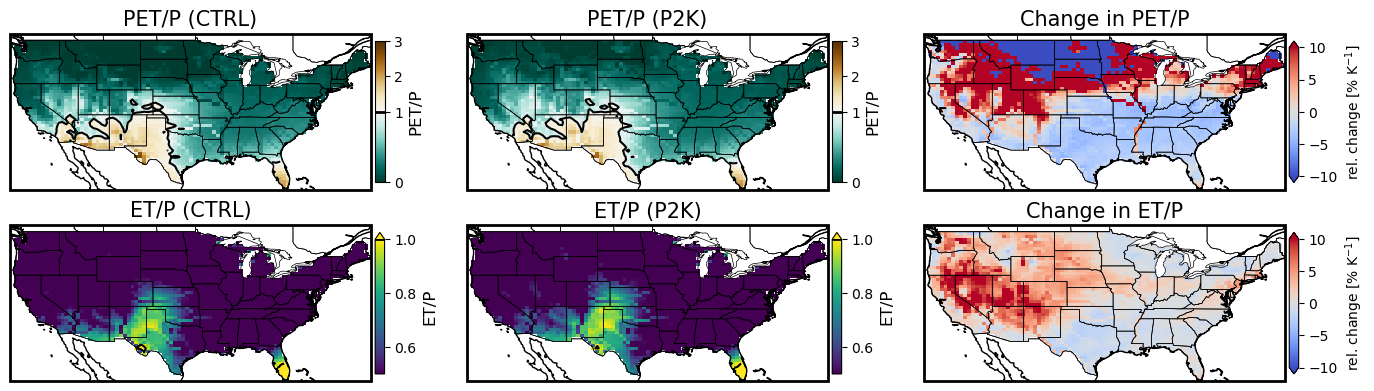

In [18]:
plot_basin_scale_pet_et_maps(
    budyko_data_ctrl_winter, budyko_data_p2K_winter, dT,
    outfile='plots/budyko_analysis/basin_scale_pet_ind_ctrl_p2K.png',
    region='conus_land')
